<a href="https://colab.research.google.com/github/TAITKit/NewsSpider/blob/master/shorturl_at_blwKP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 下載程式碼
使用git clone 指令從github下載程式碼。

In [0]:
!git clone https://github.com/BogiHsu/2019-AI-Summer-School-Voice-Conversion.git

Cloning into '2019-AI-Summer-School-Voice-Conversion'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 94 (delta 36), reused 73 (delta 18), pack-reused 0
Unpacking objects: 100% (94/94), done.


# 安裝必要套件
用pip3安裝requierments.txt中所列出的必要套件。

In [0]:
import os
os.chdir('2019-AI-Summer-School-Voice-Conversion')
!pip3 install -r requirements.txt

     |████████████████████████████████| 225kB 10.2MB/s 


# 下載訓練好的模型

下載訓練好的模型model.pkl，並放到pkl資料夾中。

In [0]:
import os
os.chdir('2019-AI-Summer-School-Voice-Conversion')
!wget http://speech.ee.ntu.edu.tw/~jjery2243542/model.pkl
!mkdir pkl
!mv model.pkl pkl/model.pkl

--2019-08-16 07:19:57--  http://speech.ee.ntu.edu.tw/~jjery2243542/model.pkl
Resolving speech.ee.ntu.edu.tw (speech.ee.ntu.edu.tw)... 140.112.21.8
Connecting to speech.ee.ntu.edu.tw (speech.ee.ntu.edu.tw)|140.112.21.8|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132818987 (127M) [text/plain]
Saving to: ‘model.pkl’

model.pkl           100%[===================>] 126.67M  9.57MB/s    in 17s     

2019-08-16 07:20:16 (7.45 MB/s) - ‘model.pkl’ saved [132818987/132818987]



# 範例音檔
在samples中有225.wav~229.wav等五個不同speaker的聲音範例。

In [0]:
import IPython.display as ipd
ipd.Audio('samples/src4.wav')

# 聲音轉換
convert.py能一次轉換多個speaker及多個句子。

如:python3 convert.py 3 5，會選定3個speaker，倆倆互相轉換(共6種轉換方式)，每種轉換方式有5個句子。

最多可選擇5個speaker和5個句子。

轉換結果存在results資料夾中。

In [0]:
!python3 convert.py 2 2

load model from ./pkl/model.pkl
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


### 播放轉換結果

In [0]:
import IPython.display as ipd
ipd.Audio('results/p225_p226/225_226_358.wav')

# 使用個人聲音做轉換


### 錄音
recorder.py中的get_audio()函數已寫好如何在colab中錄音，當圖示跳出即開始錄音。

錄音完成存檔檔名為record.wav。

In [0]:
from scipy.io import wavfile
from recorder import get_audio
audio = get_audio()
filename = 'record.wav'
wavfile.write(filename, 16000, audio)

### 轉換


In [0]:
# make conversion
import torch
import numpy as np
from convert import get_model
from scipy.io.wavfile import write
from torch.autograd import Variable
from preprocess.tacotron.norm_utils import spectrogram2wav, get_spectrograms

讀取模型

In [0]:
solver = get_model(hps_path = './hps/vctk.json', model_path = './pkl/model.pkl')

load model from ./pkl/model.pkl


製作speaker-id對照表

In [0]:
with open('./hps/en_speaker_used.txt') as f:
	speakers = [line.strip() for line in f]
speaker2id = {speaker:i for i, speaker in enumerate(speakers)}

準備輸入資料

In [0]:
speaker = '225'
_, spec = get_spectrograms('samples/src4.wav') # 1025*80
spec_expand = np.expand_dims(spec, axis = 0) #1*1025*80
spec_tensor = torch.from_numpy(spec_expand).type(torch.FloatTensor)
c = Variable(torch.from_numpy(np.array([speaker2id[speaker]]))).cuda()

使用模型做轉換

In [0]:
result = solver.test_step(spec_tensor, c, gen = True)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


頻譜轉音訊並存檔

In [0]:
result = result.squeeze(axis = 0).transpose((1, 0))
wav_data = spectrogram2wav(result)
write('result.wav', rate = 16000, data = wav_data)

### 播放轉換結果

In [0]:
# listen sample audio
import IPython.display as ipd
ipd.Audio('result.wav')

# 結果可視化
將轉換前即轉換後的聲音檔分別繪成頻譜圖。

### 轉換前(錄音檔)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7609: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0.5, 1.0, 'Spectrogram')

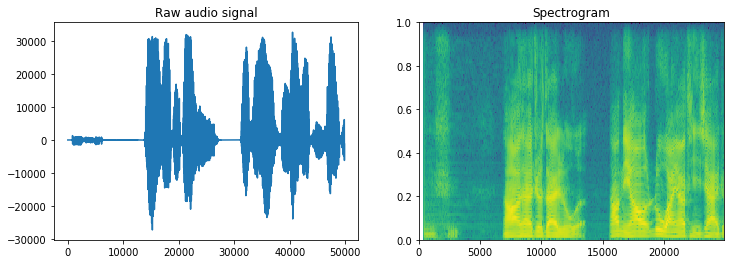

In [0]:
%matplotlib inline
from scipy.io import wavfile
from matplotlib import pyplot as plt
rate, x = wavfile.read('record.wav')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(x)
ax1.set_title('Raw audio signal')
ax2.specgram(x, Fs = 2)
ax2.set_title('Spectrogram')

### 轉換後(模型輸出)

Text(0.5, 1.0, 'Spectrogram')

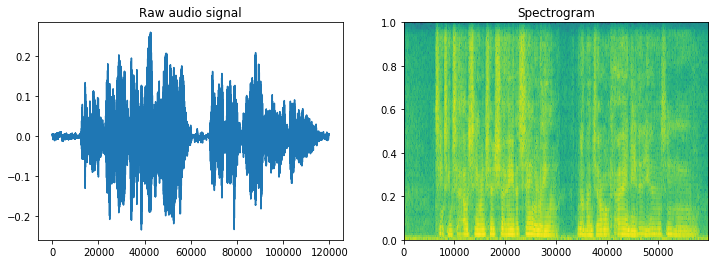

In [0]:
%matplotlib inline
from scipy.io import wavfile
from matplotlib import pyplot as plt
rate, x = wavfile.read('result.wav')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(x)
ax1.set_title('Raw audio signal')
ax2.specgram(x, Fs = 2)
ax2.set_title('Spectrogram')